- title: Inferring attribute preferences
- date: 2018-07-11
- category: python
- tags: pymc3

In this post, I demonstrate how one can use PyMC3 to infer a person's preferences for several attributes based
on the choices they make between sets of items (for which we know the attribute values).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.simplefilter('ignore')  # Don't do this. This is bad.

import pymc3 as pm
import theano.tensor as tt

# Not necessary, but it makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)
sns.set_palette('tab10')

## Generate a fake choice dataset

Imagine we have data from one participant making 200 three-alternative choices.
The items are all unique, but they share a set of four features given by $\phi$. 
We assume that the participant makes choices by noisly maximizing utility given by $U$,
and that the utility of each option is a weighted sum of those features. $\alpha$ is an
inverse-temperature parameter.

$$
U(c) = \theta^\top \phi(c) \\
\Pr(c \mid \mathcal{C}) = \frac {e^{\alpha U(C)}} {\sum_{c' \in \mathcal{C}} e^{\alpha U(c')}}\\
$$

In [2]:
# Stimuli
N_FEATURE = 4
N_TRIAL = 200
N_CHOICE = 3
choice_sets = np.random.rand(N_TRIAL, N_CHOICE, N_FEATURE)

# Unknown human parameters
CHOICE_TEMP = 1
PREFERENCE = [1, 2, -1, 0]

def softmax(x, temp=1, np=np):
    ex = np.exp((x - x.max(-1, keepdims=True)) / temp)
    return ex / ex.sum(-1, keepdims=True)

def fake_data(preference, choice_temp):
    utility = np.dot(choice_sets, preference)
    p_choice = softmax(utility, temp=choice_temp)
    choices = pm.Categorical.dist(p_choice).random()
    return choices

choices = fake_data(PREFERENCE, CHOICE_TEMP)

## Inference

The model code looks remarkably similar to the code we used to actually generate the data, but
instead of specifying the preferences, we create a random variable that we will infer a posterior
distribution over.

In [3]:
with pm.Model() as model:
    preference = pm.Normal('preference', 0, 10, shape=4)  # somewhat weak prior

    # In some cases it makes sense to infer the decision temperature. However,
    # in this case, temperature effectively scales the preference, so you can't
    # identify both. You can include both though—the model will just find the
    # tradeoff that maximizes the prior probability.
    # temp = pm.HalfCauchy('temp', 1)  # weak prior
    temp = 1
    
    utility = tt.dot(choice_sets, preference)
    p_choice = softmax(utility, np=tt)  # use theano instead of numpy for efficiency
    pm.Categorical('choices', p_choice, observed=choices)
    trace = pm.sample()  # Run MCMC to generate samples from the posterior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [preference]
100%|██████████| 1000/1000 [00:02<00:00, 436.96it/s]


## Results

We are able to recover the parameters with reasonable accuracy. Note that there are two
estimates for each parameter. Each is from a separate MCMC chain. If the two chains make
very different predictions, try increasing the number of samples, or use more than two chains
e.g. `pm.sample(njobs=30)` to wash out the bias in each individual chain. If you go this route, you might
want to run it on a computer with many CPUs so that the chains can run in parallel.

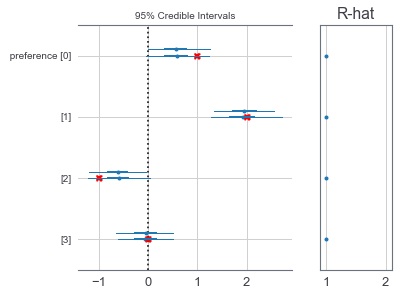

In [4]:
pm.forestplot(trace, varnames=['preference'])
# Plot the true values with red Xs
plt.sca(plt.gcf().get_axes()[1])
plt.plot(PREFERENCE, -np.arange(N_FEATURE), 'X', c='red');